1- Import XRay Images


In [126]:
import os
import cv2
import numpy as np
# traitement dataframe
import pandas as pd
# apprentissage automatique
import tensorflow as tf
# permet de faire des graphiques
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score


2- Class XrayLoader

In [163]:
class XrayLoader:
    def __init__(self, x_train=None, x_train_reshaped=None, x_train_masked=None, y_train=None, x_val=None, x_val_reshaped=None, x_val_masked=None, y_val=None, 
    x_test=None, x_test_reshaped=None, x_test_masked=None, y_test=None):
        self.x_train = x_train
        self.x_train_reshaped = x_train_reshaped
        self.y_train = y_train
        self.x_val = x_val
        self.x_val_reshaped = x_val_reshaped
        self.y_val = y_val
        self.x_test = x_test
        self.x_test_reshaped = x_test_reshaped
        self.y_test = y_test
        self.data_folder = './chest_Xray'
        self.image_size = (256, 256)
        self.batch_size = 5


    def load_data(self):
        subfolders = ["train", "val", "test"]
        categories = ["NORMAL", "PNEUMONIA"]
        data = {}

        for subfolder in subfolders:
            data[subfolder] = {"x": [], "y": []}
            for category in categories:
                # pour avoir tous les chemins des 6 dossiers
                folder_path = os.path.join(self.data_folder, subfolder, category)
                # liste de toutes les images
                images_files = os.listdir(folder_path)
                for file_name in images_files:
                    image_path = os.path.join(folder_path, file_name)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (256, 256))
                    data[subfolder]["x"].append(img / 255)
                    data[subfolder]["y"].append(category)

        self.x_train = np.array(data["train"]["x"])
        self.x_train_reshaped = self.x_train.reshape(-1, 256 * 256)
        self.y_train = data["train"]["y"]
        self.x_val = np.array(data["val"]["x"])
        self.x_val_reshaped = self.x_val.reshape(-1, 256 * 256)
        self.y_val = data["val"]["y"]
        self.x_test = np.array(data["test"]["x"])
        self.x_test_reshaped = self.x_test.reshape(-1, 256 * 256)
        self.y_test = data["test"]["y"]


    def load_data_faster(self):
        (self.x_train, self.y_train) = self.make_dataset(self.data_folder + '/train', self.batch_size, self.image_size)
        (self.x_val, self.y_val) = self.make_dataset(self.data_folder + '/val', self.batch_size, self.image_size)
        (self.x_test, self.y_test) = self.make_dataset(self.data_folder + '/test', self.batch_size, self.image_size)

    def make_dataset(self, directory, batch_size, image_size):
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=directory,
            labels='inferred',
            label_mode='int',
            color_mode='grayscale',
            image_size=image_size,
            batch_size=batch_size
        )
        datas = [x for x, _ in dataset]
        labels = [y for _, y in dataset]
        #Using the np.concatenate to convert datas and labels into single np.array 
        return np.concatenate(datas, axis=0), np.concatenate(labels, axis=0)

    def display_image(self, dataset, index):
        if dataset == 'train':
            image = self.x_train[index]
            label = self.y_train[index]
        elif dataset == 'test':
            image = self.x_test[index]
            label = self.y_test[index]
        else:
            raise ValueError('Invalid dataset. Choose either "train" or "test".')

        plt.imshow(image, cmap="gray")
        plt.title(f'Image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()

    def display_category_means(self):
        normal_mean = self.calculate_category_mean(self.x_train, self.y_train, "NORMAL")
        pneumonia_mean = self.calculate_category_mean(self.x_train, self.y_train, "PNEUMONIA")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(normal_mean, cmap="gray")
        plt.title("Mean NORMAL Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pneumonia_mean, cmap="gray")
        plt.title("Mean PNEUMONIA Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def calculate_category_mean(images, labels, category):
        images = np.array(images)
        labels = np.array(labels)
        category_images = images[labels == category]
        mean_image = np.mean(category_images, axis=0)
        return mean_image

    def display_xray_distribution(self):
        test = (self.y_test.count("NORMAL"), self.y_test.count("PNEUMONIA"))
        train = (self.y_train.count("NORMAL"), self.y_train.count("PNEUMONIA"))
        val = (self.y_val.count("NORMAL"), self.y_val.count("PNEUMONIA"))

        # Tracer les graphiques de distribution
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].bar(["NORMAL", "PNEUMONIA"], train)
        ax[0].set_title("Train Distribution")
        ax[1].bar(["NORMAL", "PNEUMONIA"], val)
        ax[1].set_title("Validation Distribution")
        ax[2].bar(["NORMAL", "PNEUMONIA"], test)
        ax[2].set_title("Test Distribution")
        plt.show()



In [164]:
temporary_loader = XrayLoader()
temporary_loader.load_data()
xtrain = temporary_loader.x_train
xtrain_reshaped = temporary_loader.x_train_reshaped
ytrain = temporary_loader.y_train
xtest = temporary_loader.x_test
xtest_reshaped = temporary_loader.x_test_reshaped
ytest = temporary_loader.y_test
xval = temporary_loader.x_val
xval_reshaped = temporary_loader.x_val_reshaped
yval = temporary_loader.y_val


In [165]:
loader = XrayLoader(x_train=xtrain, x_train_reshaped=xtrain_reshaped, y_train=ytrain,
                    x_val=xval,
                    x_val_reshaped=xval_reshaped, y_val=yval, x_test=xtest,
                    x_test_reshaped=xtest_reshaped,
                    y_test=ytest)

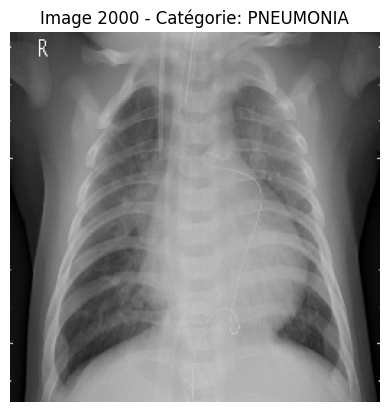

In [130]:
loader.display_image("train", 2000)

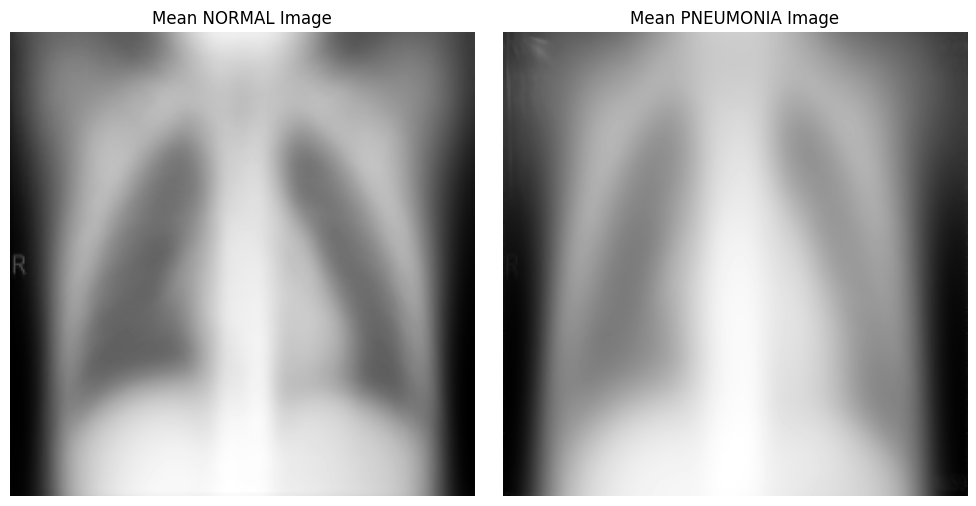

In [131]:
loader.display_category_means()

In [103]:
# loader.x_train

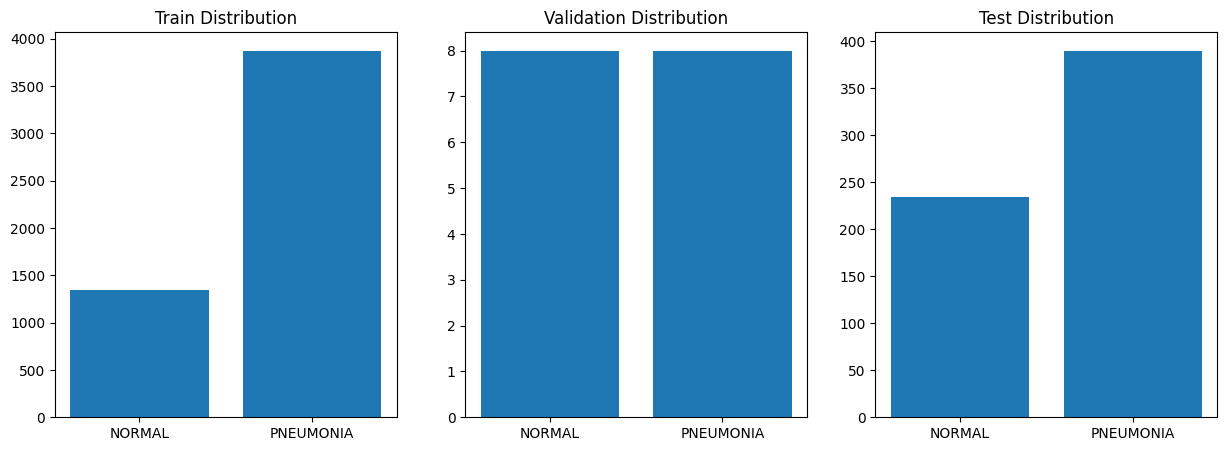

In [104]:
loader.display_xray_distribution();

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(loader.x_train_reshaped, loader.y_train)

y_pred = model.predict(loader.x_test_reshaped)
accuracy = accuracy_score(loader.y_test, y_pred)

print('Accuracy:', accuracy)

recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)

Accuracy: 0.7564102564102564
Recall :  0.6777777777777778


## Heatmap pour RandomForest

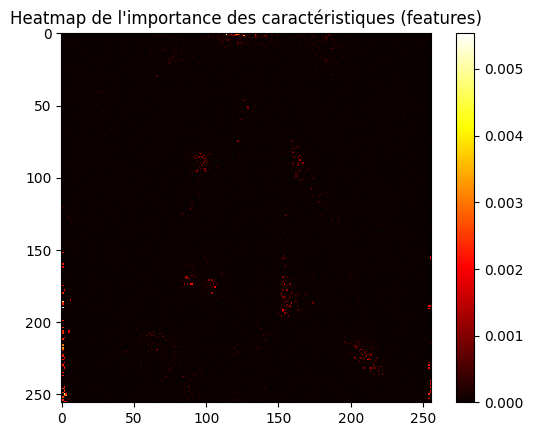

In [168]:

# Obtenir l'importance des caractéristiques
feature_importances = model.feature_importances_

# Reshape l'importance des caractéristiques pour correspondre à la forme de l'image originale
importance_map = feature_importances.reshape(loader.image_size)

# Afficher la heatmap
plt.imshow(importance_map, cmap='hot', interpolation='nearest')
plt.title('Heatmap de l\'importance des caractéristiques (features)')
plt.colorbar()
plt.show()


In [143]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)
model.fit(loader.x_train_reshaped, loader.y_train)

y_pred = model.predict(loader.x_test_reshaped)
accuracy = accuracy_score(loader.y_test, y_pred)

print('Accuracy:', accuracy)

recall = recall_score(loader.y_test, y_pred, average='macro')
print("Recall : ", recall)

Accuracy: 0.7932692307692307
Recall :  0.7346153846153847


In [111]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
# applique la validation croisée en 5 plis et obtient les scores de précision
scores = cross_val_score(model, loader.x_train_reshaped, loader.y_train, cv=5, scoring='accuracy')

print("Scores de précision pour chaque pli de la validation croisée:")
print(scores)

print("Précision moyenne : {:.4f}".format(scores.mean()))

Scores de précision pour chaque pli de la validation croisée:
[0.95019157 0.95685523 0.96548418 0.95206136 0.96260786]
Précision moyenne : 0.9574


In [112]:
from sklearn.model_selection import cross_val_score

model = KNeighborsClassifier()
# applique la validation croisée en 5 plis et obtient les scores de précision
scores = cross_val_score(model, loader.x_train_reshaped, loader.y_train, cv=5, scoring='accuracy')

print("Scores de précision pour chaque pli de la validation croisée:")
print(scores)

print("Précision moyenne : {:.4f}".format(scores.mean()))

Scores de précision pour chaque pli de la validation croisée:
[0.93295019 0.94247363 0.94343241 0.915628   0.93192713]
Précision moyenne : 0.9333


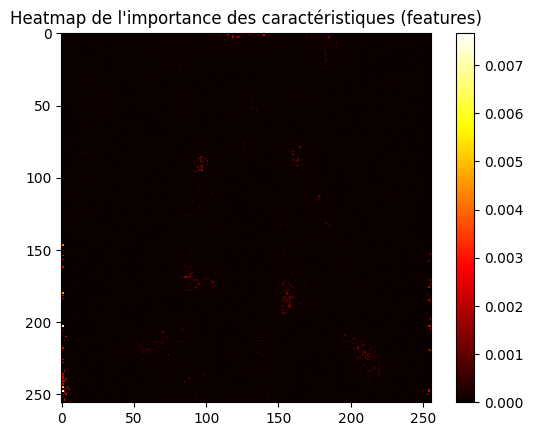